### Markov Chain


Let's build our first Markov Chain together. 

You are a real astronomer (not a theorethical guy like me) and are planning an expensive observational campaign. You want to know how likely it is that tomorrow night will be clear given the weather tonight (clear or cloudy). The key piece of information here is that the weather tomorrow depends on the weather today. From past history, you know that:

$$p({\rm clear \; tomorrow} \, |\,  {\rm cloudy \; today}) = 0.5,$$

which means that

$$p({\rm cloudy \; tomorrow} \, |\, {\rm cloudy \; today}) = 0.5.$$

We also have

$$p({\rm cloudy \; tomorrow} \, |\, {\rm clear \; today}) = 0.1,$$

which means that

$$p({\rm clear \; tomorrow} \, |\, {\rm clear \; today}) = 0.9.$$


- We can start with the sky conditions today and make predictions going forward more and more into the future.
- This will look like a big decision tree. 
- After enough days, we'll reach equilibrium probabilities that have to do with the mean weather statistics (ignoring seasons) and we'll arrive at

$$p({\rm clear}) = 0.83,$$

and 

$$p({\rm cloudy}) = 0.17.$$

You get the same answer for day $N$ as day $N+1$ and it doesn't matter whether it was clear or cloudy on the day that you started. The steps that we have taken in this process are a **MARKOV CHAIN**.

Here is an illustration of this process from an article in [towarddatascience.com](https://towardsdatascience.com/introduction-to-markov-chains-50da3645a50d).

![image.png](https://miro.medium.com/max/416/1*frksGjINf5oTjx7WL81U3w.png)

#### Tasks

- Start off on a cloud day. 
- Implement your weather forecast based on the above probabilities
- Run your simulator for N days (with $N\gtrsim 10^4$)
- Prepare a plot with the number of days on the x axis and the "running average" on the y axis (that is, the cumulative number of, say, sunny days over the number of days so far). This is called a **trace-plot**, showing how our estimate of $p(\mathrm{clear})$ evolves as the chain samples.  
- Prepare a histogram of the above plot. This reveals the distribution of $p(\mathrm{clear})$. - Use a summary statistics to determine the most likely value and an error on our estimate.

**Important:** 
- In MCMC the process must be **stationary** which basically means that the chain statistics look the same no matter which chunk you look at, e.g. first half, second half, or every other point, etc.  
- Obviously that isn't going to be the case in the early steps of the chain. In our example above, after some time the process was stationary, but not in the first few days.
- So, there is a **burn-in** phase that needs to be discarded. How one determines the number of early steps to discard as burn-in is tricky, but ***you should always start with a traceplot of your samples!!!***


#### Tasks

- In the above example, experiment with chopping off different numbers of initial points as burn-in.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import hist
import astroML.stats

In [11]:
# Chain
def MCMC(isClear) : 

    random = np.random.uniform(0,1,1)
    if isClear:
        if random > 0.9:
            isClear = False
    else:
        if random > 0.5:
            isClear = True

    return isClear




In [12]:
#Initial Condition (Today)
isClear = False
Sunny = [0] #a sort of cumulative sum
Cloudy = [1] #a sort of cumulative sum

#Simulation for N days
days = np.arange(1,100001,1)
for i in days[:-1]:
    isClear = MCMC(isClear) # (Tomorrow)
    if isClear:
        Sunny.append( (Sunny[-1]+1))
        Cloudy.append(Cloudy[-1])
    else:
        Sunny.append( Sunny[-1])
        Cloudy.append( (Cloudy[-1] +1))

print(len(Sunny))
print(len(Cloudy))
print(len(days))


100000
100000
100000


Text(0, 0.5, 'Running Average')

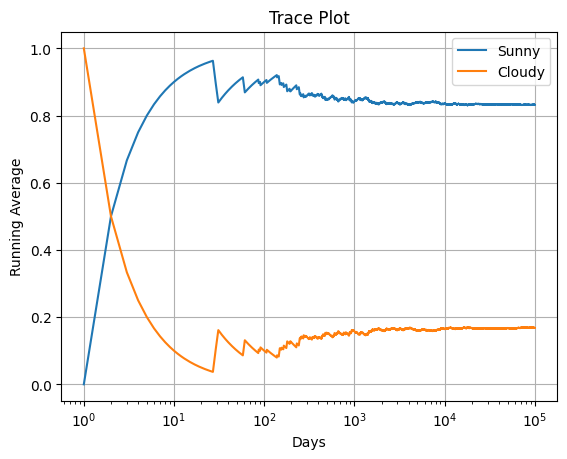

In [13]:
plt.title('Trace Plot')
plt.plot(days, Sunny/days, label='Sunny')
plt.plot(days, Cloudy/days, label='Cloudy')
plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel('Days')
plt.ylabel('Running Average')

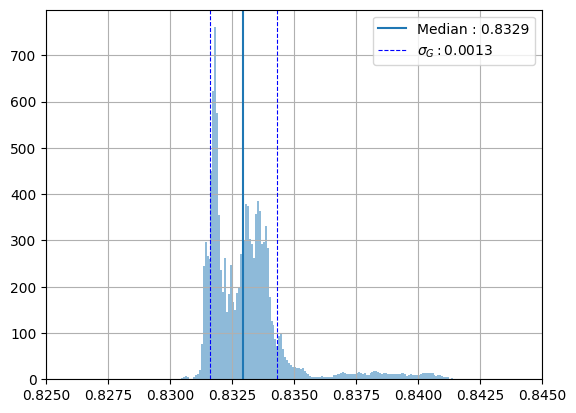

In [14]:
hist(Sunny/days, bins='freedman', density=True, alpha=0.5)
plt.axvline(np.median(Sunny/days), label = 'Median : {:.4f}'.format(np.median(Sunny/days)))
plt.axvline(np.median(Sunny/days) + astroML.stats.sigmaG(Sunny/days),color = 'blue',label = r'$\sigma_G : ${:.4f}'.format(astroML.stats.sigmaG(Sunny/days)), linestyle='--', linewidth=0.8)
plt.axvline(np.median(Sunny/days) - astroML.stats.sigmaG(Sunny/days),color = 'blue', linestyle='--', linewidth=0.8)
plt.xlim(0.825, 0.845)
plt.legend()
plt.grid()

In [15]:
print('Sunny : ', np.median(Sunny/days))
print('Cloudy : ',np.median(Cloudy/days))

Sunny :  0.83294581206021
Cloudy :  0.16705418793979004


In [16]:
print('Sunny Error : ',astroML.stats.sigmaG(Sunny/days))
print('Cloudy Error : ',astroML.stats.sigmaG(Cloudy/days))

Sunny Error :  0.0013454389854236017
Cloudy Error :  0.0013454389854236223


### Burn-in 

In [17]:
n_discard=[0, 100, 1000]

Sunny_burnin=[]
Cloudy_burnin = []
days_burnin = []

for n in n_discard:
    Sunny_burnin.append(Sunny[n:])
    Cloudy_burnin.append(Cloudy[n:])
    days_burnin.append(days[n:])

N burning: 0
Median : 0.83294581206021
Sigma G : 0.0013454389854236017
_____
N burning: 100
Median : 0.832944294436987
Sigma G : 0.0013437449745467983
_____
N burning: 1000
Median : 0.8329233643864777
Sigma G : 0.0013302991414289303
_____


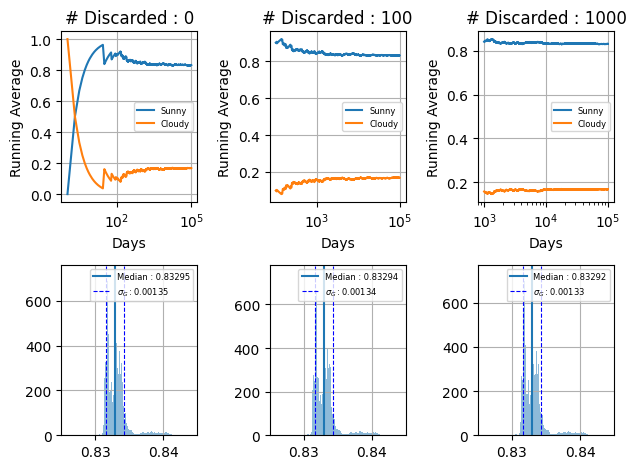

In [18]:
fig, ax = plt.subplots(2,3)

for i in range(len(n_discard)):

    #Trace Plot
    ax[0, i].plot(days_burnin[i], Sunny_burnin[i]/days_burnin[i], label='Sunny')
    ax[0, i].plot(days_burnin[i], Cloudy_burnin[i]/days_burnin[i], label='Cloudy')
    ax[0, i].set_xscale('log')
    ax[0, i].grid()
    ax[0, i].legend(prop={'size':6})
    ax[0, i].set_xlabel('Days')
    ax[0, i].set_ylabel('Running Average')
    ax[0, i].set_title('# Discarded : {}'.format(n_discard[i]))


    #Pdf
    ax[1, i].hist(Sunny_burnin[i]/days_burnin[i], bins='fd', density=True, alpha=0.5)
    ax[1, i].axvline(np.median(Sunny_burnin[i]/days_burnin[i]), label = 'Median : {:.5f}'.format(np.median(Sunny_burnin[i]/days_burnin[i])))
    ax[1, i].axvline(np.median(Sunny_burnin[i]/days_burnin[i]) + astroML.stats.sigmaG(Sunny_burnin[i]/days_burnin[i]),color = 'blue',label = r'$\sigma_G : ${:.5f}'.format(astroML.stats.sigmaG(Sunny_burnin[i]/days_burnin[i])), linestyle='--', linewidth=0.8)
    ax[1, i].axvline(np.median(Sunny_burnin[i]/days_burnin[i]) - astroML.stats.sigmaG(Sunny_burnin[i]/days_burnin[i]),color = 'blue', linestyle='--', linewidth=0.8)
    ax[1, i].set_xlim(0.825, 0.845)
    ax[1, i].legend(prop={'size':6})
    ax[1, i].grid()

    print('N burning: {}'.format(n_discard[i]))
    print('Median : {}'.format(np.median(Sunny_burnin[i]/days_burnin[i])))
    print('Sigma G : {}'.format(astroML.stats.sigmaG(Sunny_burnin[i]/days_burnin[i])))
    print('_____')

plt.tight_layout()